In [1]:
# Install standard dependencies (same as before)
%pip install matplotlib scikit-learn "opencv-python>4" imutils

# Install PyTorch
%pip install torch torchvision torchaudio

In [20]:
import os
import pickle
import glob
import math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from lab_2_helpers import *

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [21]:
!tar -xJf captcha-images.tar.xz

CAPTCHA_IMAGE_FOLDER = "./captcha-images"
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))

def extract_captcha_text(image_path):
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]

def load_transform_image(image_path):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_padded = cv2.copyMakeBorder(image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]

In [22]:
TVT_SPLIT_SEED = 31528476

captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


In [23]:
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w / h > 1.25:
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            char_regions.append((x, y, w, h))

    if len(char_regions) != 4:
        return None
    char_regions.sort(key=lambda x: x[0])

    char_images = []
    for x, y, w, h in char_regions:
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        char_images.append(char_image)
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)
        char_counts[char] = char_count + 1

FORCE_EXTRACT_CHAR = False
char_counts = {}
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        char_images = extract_chars(captcha_image)
        if char_images is None: continue
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

In [24]:
LABELS_PATH = "./labels.pkl"

def make_feature(image):
    image_resized = resize_to_fit(image, 20, 20)
    # PyTorch expects (Channels, Height, Width)
    feature = image_resized[None, ...] # Shape: (1, 20, 20)
    return feature

def make_feature_label(image_path):
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    label = image_path.split(os.path.sep)[-2]
    return feature, label

features_tv_list, labels_tv_list = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Scale to [0, 1] and convert to numpy
features_tv = np.array(features_tv_list, dtype="float32") / 255.0

# Encode labels to integers for PyTorch CrossEntropy
lb = LabelBinarizer()
labels_one_hot = lb.fit_transform(labels_tv_list)
labels_tv = np.argmax(labels_one_hot, axis=1) # Integer indices
n_classes = len(lb.classes_)

# Split
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_tv, test_size=0.25, random_state=955996
)

with open(LABELS_PATH, "wb") as f:
    pickle.dump(lb, f)

# Create PyTorch DataLoaders
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
vali_ds = TensorDataset(torch.from_numpy(X_vali), torch.from_numpy(y_vali).long())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_ds, batch_size=BATCH_SIZE)

In [25]:
class CaptchaCNN(nn.Module):
    def __init__(self, num_classes):
        super(CaptchaCNN, self).__init__()
        # Block 1: (1, 20, 20) -> (20, 20, 20) -> (20, 10, 10)
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: (20, 10, 10) -> (50, 10, 10) -> (50, 5, 5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, padding=2) # Using 5x5 to match 'same' logic easily
        self.pool2 = nn.MaxPool2d(2, 2)

        # FC Layers
        self.fc1 = nn.Linear(50 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # Output logits
        return x

model = CaptchaCNN(n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
N_EPOCHS = 10
MODEL_WEIGHTS_PATH = "./captcha-model.pth"
FORCE_TRAINING = True

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    print("Starting Training...")
    for epoch in range(N_EPOCHS):
        model.train()
        train_loss, correct = 0, 0

        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, lbls)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(lbls.view_as(pred)).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for imgs, lbls in vali_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                output = model(imgs)
                val_loss += criterion(output, lbls).item()
                pred = output.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(lbls.view_as(pred)).sum().item()

        print(f"Epoch {epoch+1}/{N_EPOCHS} - "
              f"Loss: {train_loss/len(train_loader):.4f} - Acc: {correct/len(train_ds):.4f} - "
              f"Val Loss: {val_loss/len(vali_loader):.4f} - Val Acc: {val_correct/len(vali_ds):.4f}")

    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
else:
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))
    model.eval()

Starting Training...
Epoch 1/10 - Loss: 1.9189 - Acc: 0.4875 - Val Loss: 0.4334 - Val Acc: 0.9057
Epoch 2/10 - Loss: 0.2012 - Acc: 0.9585 - Val Loss: 0.2112 - Val Acc: 0.9675
Epoch 3/10 - Loss: 0.0808 - Acc: 0.9850 - Val Loss: 0.1531 - Val Acc: 0.9753
Epoch 4/10 - Loss: 0.0415 - Acc: 0.9936 - Val Loss: 0.1159 - Val Acc: 0.9843
Epoch 5/10 - Loss: 0.0212 - Acc: 0.9963 - Val Loss: 0.1369 - Val Acc: 0.9820
Epoch 6/10 - Loss: 0.0109 - Acc: 0.9974 - Val Loss: 0.1314 - Val Acc: 0.9809
Epoch 7/10 - Loss: 0.0071 - Acc: 0.9993 - Val Loss: 0.1114 - Val Acc: 0.9854
Epoch 8/10 - Loss: 0.0041 - Acc: 0.9993 - Val Loss: 0.1398 - Val Acc: 0.9854
Epoch 9/10 - Loss: 0.0011 - Acc: 1.0000 - Val Loss: 0.1401 - Val Acc: 0.9854
Epoch 10/10 - Loss: 0.0087 - Acc: 0.9985 - Val Loss: 0.1412 - Val Acc: 0.9787


In [27]:
with open(LABELS_PATH, "rb") as f:
    lb = pickle.load(f)

model.eval()
extract_failed_indices = []
char_images_test = []

for i, captcha_image in enumerate(captcha_images_test):
    chars = extract_chars(captcha_image)
    if chars:
        char_images_test.extend(chars)
    else:
        extract_failed_indices.append(i)
        # Dummy chars to keep alignment
        char_images_test.extend([np.zeros((20, 20), dtype="uint8")] * 4)

# Prepare features
features_test = np.array([make_feature(img) for img in char_images_test], dtype="float32") / 255.0
X_test_tensor = torch.from_numpy(features_test).to(device)

# Predict
with torch.no_grad():
    logits = model(X_test_tensor)
    # Convert logits to probabilities then to labels
    probs = F.softmax(logits, dim=1).cpu().numpy()
    preds_chars = lb.inverse_transform(probs)

# Group results
preds_test = ["".join(chars) for chars in group_every(preds_chars, 4)]
for i in extract_failed_indices:
    preds_test[i] = "----"

# Calculate Accuracy
n_test = len(captcha_texts_test)
n_correct = sum(1 for p, a in zip(preds_test, captcha_texts_test) if p == a)

print(f"# Test CAPTCHAs: {n_test}")
print(f"# Correct: {n_correct}")
print(f"Accuracy: {n_correct/n_test:.4f}")

# Test CAPTCHAs: 228
# Correct: 216
Accuracy: 0.9474



--- Correct Predictions ---
Figure(2000x500)

--- Incorrect Predictions ---
Figure(2000x600)


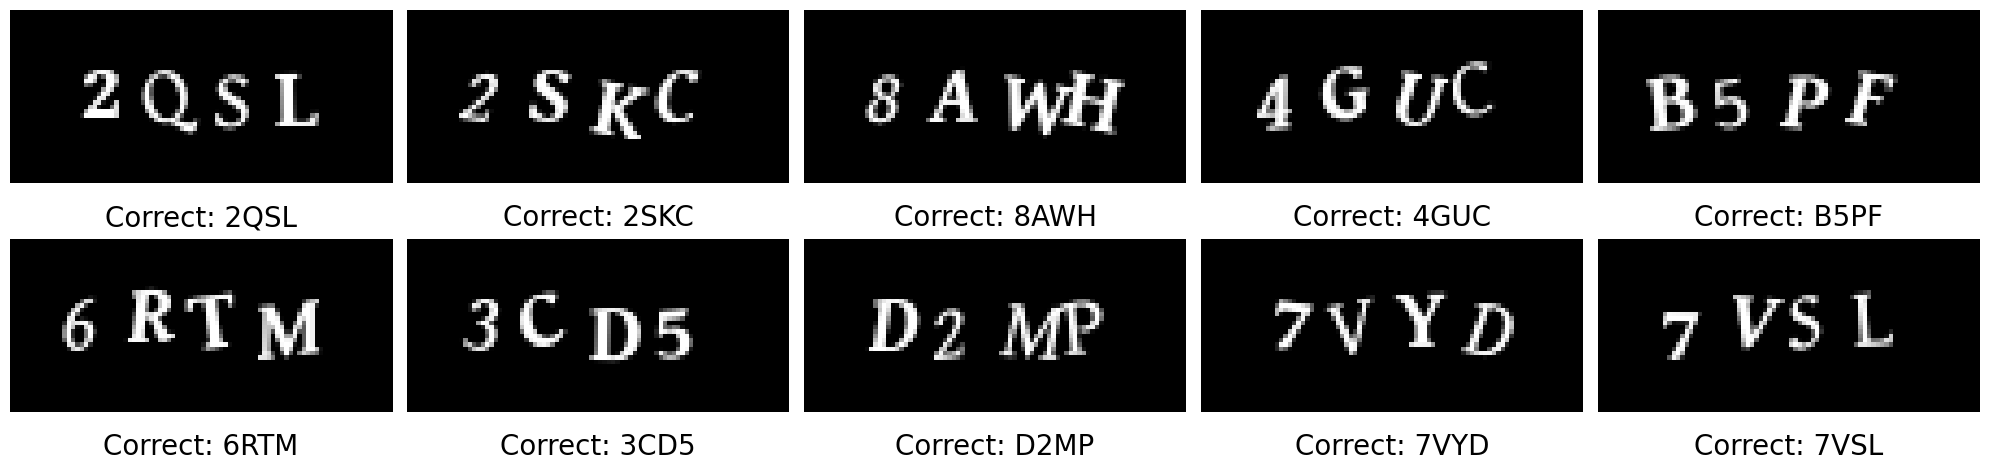

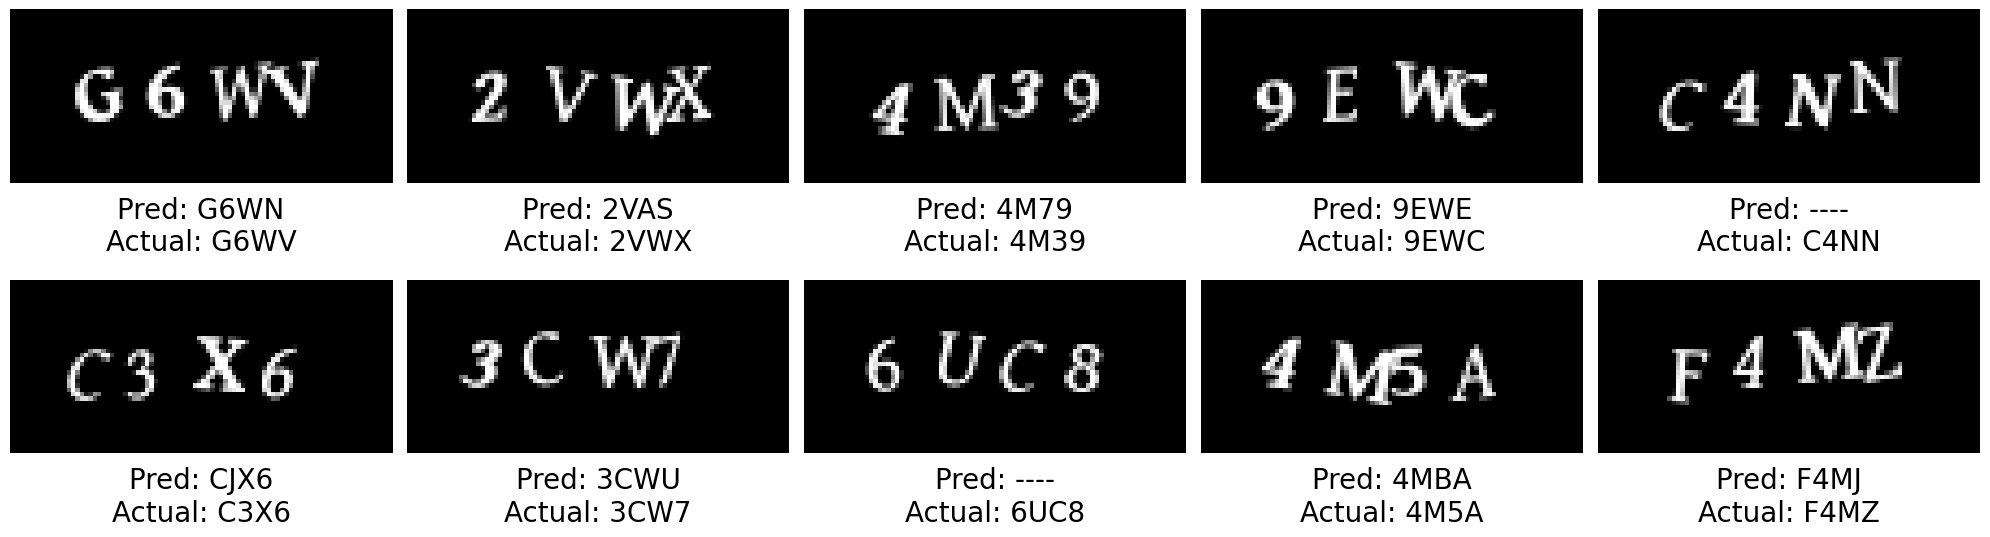

In [28]:
# Extract sample indices
correct_indices = [i for i, (p, a) in enumerate(zip(preds_test, captcha_texts_test)) if p == a][:10]
incorrect_indices = [i for i, (p, a) in enumerate(zip(preds_test, captcha_texts_test)) if p != a][:10]

print("\n--- Correct Predictions ---")
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

if incorrect_indices:
    print("\n--- Incorrect Predictions ---")
    print_images(
        [captcha_images_test[i] for i in incorrect_indices],
        texts=[f"Pred: {preds_test[i]}\nActual: {captcha_texts_test[i]}" for i in incorrect_indices],
        n_rows=2,
        fig_size=(20, 6),
        text_center=(0.5, -0.25)
    )